In [1]:
import skopt # scikit-optimize library

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [5]:
# Prepare data set for demonstration
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(569, 30) (569,)
(426, 30) (143, 30) (426,) (143,)


In [6]:
def loss_function(C, X_train_scaled, X_test_scaled, y_train, y_test):
    # objective function to minimize using Bayesian optimization
    model = SVC(C=C)
    model.fit(X_train_scaled, y_train)
    f = roc_auc_score(y_test, model.predict(X_test_scaled))
    return -f # lower is better!

# set boundaries of C to optimize
dimensions = [(0.1, 10.0)]

opt = skopt.Optimizer(dimensions = dimensions,
                      base_estimator = "gp", # Gaussian Process Regressor
                      initial_point_generator = "random", # random numbers for the initial point
                      acq_func = "LCB", # Acquisition function
                      random_state = 42)

n_iter = 10 # iterate the optimize for 100 turns

for count in range(n_iter):
    params = opt.ask()
    target = loss_function(*params, X_train_scaled, X_test_scaled, y_train, y_test)
    res = opt.tell(params, target)

print("Best iteration:")
print("C: {:>5.2f}, roc_auc_score: {:.3f}".format(res.x[0], -res.fun))

Best iteration:
C:  1.92, roc_auc_score: 0.985


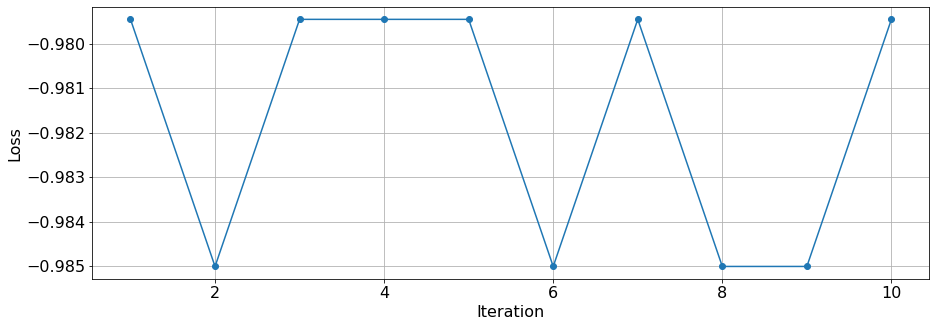

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, len(res.func_vals) + 1, 1), res.func_vals, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()